# dataloader demo

In [1]:
# Jupyter notebook setup
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Standard imports
import sys
import os
from pathlib import Path

# Add project root to path if needed
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
import matplotlib.pyplot as plt
from os import path

from tqdm import tqdm
import torch
from omegaconf import OmegaConf, open_dict

from experanto.datasets import ChunkDataset
from experanto.dataloaders import get_multisession_dataloader

#### Load Config Object from .yaml file

In [3]:
from experanto.configs import DEFAULT_CONFIG as cfg

print(OmegaConf.to_yaml(cfg))

dataset:
  global_sampling_rate: null
  global_chunk_size: null
  add_behavior_as_channels: false
  replace_nans_with_means: false
  cache_data: false
  out_keys:
  - screen
  - responses
  - eye_tracker
  - treadmill
  - timestamps
  normalize_timestamps: true
  modality_config:
    screen:
      keep_nans: false
      sampling_rate: 30
      chunk_size: 60
      valid_condition:
        tier: train
      offset: 0
      sample_stride: 1
      include_blanks: true
      transforms:
        normalization: normalize
        Resize:
          _target_: torchvision.transforms.v2.Resize
          size:
          - 144
          - 256
      interpolation:
        rescale: true
        rescale_size:
        - 144
        - 256
    responses:
      keep_nans: false
      sampling_rate: 8
      chunk_size: 16
      offset: 0.0
      transforms:
        normalization: standardize
      interpolation:
        interpolation_mode: nearest_neighbor
      filters:
        nan_filter:
          __tar

#### Modify the config

In [4]:
cfg.dataset.modality_config.screen.include_blanks = True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataloader.num_workers = 8

In [10]:
ls /data/test_upsampling_without_hamming_30.0Hz/

dynamic26872-17-20-Video-021a75e56847d574b9acbcc06c675055_30hz/
dynamic27204-5-13-Video-021a75e56847d574b9acbcc06c675055_30hz/
dynamic29515-10-12-Video-021a75e56847d574b9acbcc06c675055_30hz/
dynamic29623-4-9-Video-021a75e56847d574b9acbcc06c675055_30hz/
dynamic29647-19-8-Video-021a75e56847d574b9acbcc06c675055_30hz/
dynamic29712-5-9-Video-021a75e56847d574b9acbcc06c675055_30hz/
dynamic29755-2-8-Video-021a75e56847d574b9acbcc06c675055_30hz/


#### Instantiate dataloader

In [9]:
from experanto.dataloaders import get_multisession_dataloader

paths = ["/data/test_upsampling_without_hamming_30.0Hz/dynamic26872-17-20-Video-021a75e56847d574b9acbcc06c675055_30hz"]
train_dl = get_multisession_dataloader(paths, cfg)

No metadata file found at /data/test_upsampling_without_hamming_30.0Hz/dynamic17797-4-7-Video-021a75e56847d574b9acbcc06c675055_30hz/meta.json


FileNotFoundError: [Errno 2] No such file or directory: '/data/test_upsampling_without_hamming_30.0Hz/dynamic17797-4-7-Video-021a75e56847d574b9acbcc06c675055_30hz'

In [7]:
dataset_name, batch = next(iter(train_dl))
print(
    f"dataset: {dataset_name}",
)
for k, v in batch.items():
    # print(f"modality: {k}, shape: {v.shape}")
    print("Modality: ", k)
    print("Shape: ", v.shape)

# video shape: batch, times, channels, height, width
# neuronal responses: batch, times, neurons

dataset: 17797-4-7
Modality:  eye_tracker
Shape:  torch.Size([16, 60, 4])
Modality:  responses
Shape:  torch.Size([16, 16, 7493])
Modality:  screen
Shape:  torch.Size([16, 1, 60, 144, 256])
Modality:  treadmill
Shape:  torch.Size([16, 60, 1])
Modality:  timestamps


AttributeError: 'dict' object has no attribute 'shape'

## example content

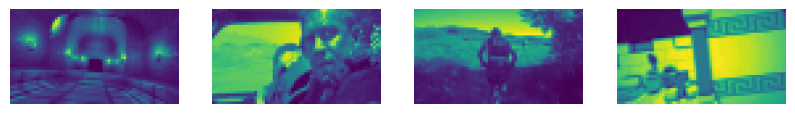

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(batch["screen"][i, 0, 0])  # video frames that the mouse sees
    ax.axis("off");

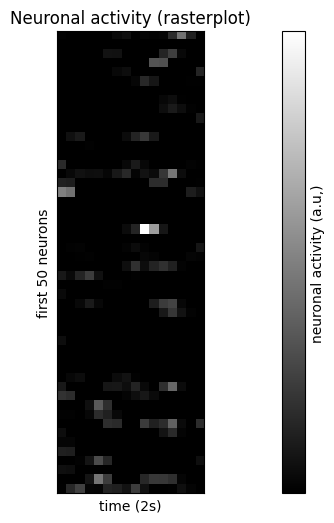

In [14]:
n_neurons = 50

fig, axs = plt.subplots(1, 1, figsize=(20, 6))
c = axs.imshow(batch["responses"][0, :, :n_neurons].T, vmin=0, cmap="gray")
axs.set(
    ylabel=f"first {n_neurons} neurons",
    xlabel="time (2s)",
    xticks=[],
    yticks=[],
    title="Neuronal activity (rasterplot)",
)
ax = plt.colorbar(c)
ax.ax.set(yticks=[], ylabel="neuronal activity (a.u,)");